**Created by:** Revekka Gershovich
**When:** Dec 3, 2024
**Purpose:** Cleaning state partisan composition data

Note that Republican and Democratic parties are actually a number of ancestor and closely aligned parties commonly considered together by political scientist merged into one. That is why there is data for Republican party before 1854. Democrats (1 in pres_gov_party) also contain a Jackson (Democrats) party (1829-1854). Republicans (2 in pres_gov_party) also contain Whig party (1834-1856), Anti-Jacksonian party (1824-1837), and Opposition Coalition which includes Whig + Republican + Free Soil parties (1850-1856). 

In [1]:
import os
import os.path as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
parent_dir = os.path.abspath("/Users/revekkagershovich/Dropbox (MIT)/StateLaws")
os.chdir(parent_dir)
assert os.path.exists(parent_dir), "parent_dir does not exist"
intermed_data_dir = "./2_data/2_intermediate/political_data"
assert os.path.exists(intermed_data_dir), "Data directory does not exist"
raw_data_dir = "./2_data/1_raw/political_data/all_partisanComposition"
assert os.path.exists(raw_data_dir), "Data directory does not exist"

The CSVs I am loading here were produced using R code called converting_icspr16_to_csv.R because somebody wrote asciiSetupReader library for R so as to extract filed from ACSII format using SAS or SPSS setup files - this setup was only used before 2000s and thus this is a very niche library. 

In [3]:
data_codes = data_codes = [f"{i:04d}" for i in range(1, 6)] 
# I am only cleaning the first three datasets even though two more exists because I have better data from Carl Klarner for the later years

print(data_codes)

['0001', '0002', '0003', '0004', '0005']


In [4]:
dataframes = {}

for data_code in data_codes:
    data_file = f"ICPSR_00016_2/DS{data_code}/00016-{data_code}-Data.csv"
    data_path = path.join(raw_data_dir, data_file)
    print(data_path)
    assert os.path.exists(data_path), "Data file does not exist"
    df = pd.read_csv(data_path)
    # Save the dataframe in the dictionary
    dataframes[f"df_{data_code}"] = df

    # Print confirmation
    print(f"DataFrame for {data_code} loaded successfully.")


./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0001/00016-0001-Data.csv
DataFrame for 0001 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0002/00016-0002-Data.csv
DataFrame for 0002 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0003/00016-0003-Data.csv
DataFrame for 0003 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0004/00016-0004-Data.csv
DataFrame for 0004 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0005/00016-0005-Data.csv
DataFrame for 0005 loaded successfully.


In [5]:
df = dataframes["df_0001"]

In [6]:
df = df.replace([999, 9999], np.nan)

# Identify columns that end with "OTH_SEATS" or "OTH_SEAT"
columns_to_drop = [col for col in df.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT'
seat_columns = [col for col in df.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df[seat_columns] = df[seat_columns]/10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df = df.rename(columns=renamed_columns)

columns_to_transform = [col for col in df.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df = df.melt(id_vars=["ICPR_STATE_CODE"], 
                    value_vars=columns_to_transform, 
                    var_name="year_variable", 
                    value_name="value")

# Extract year and variable from the melted column
melted_df["year"] = melted_df["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df["variable"] = melted_df["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df = melted_df.drop(columns=["year_variable"])

# Reshape the DataFrame: each unique variable becomes its column
reshaped_df = melted_df.pivot_table(index=["ICPR_STATE_CODE", "year"], 
                                    columns="variable", 
                                    values="value").reset_index()

non_pct_columns = [col for col in reshaped_df.columns if not col.endswith('_PCT')]

# Convert these columns to integers
reshaped_df[non_pct_columns] = reshaped_df[non_pct_columns].astype('Int64') 

I am mapping in the next cell the following parties to republicans and democrats: 
Democratic (100 - 1): 
Republican (200 - 2): Whigs (29), Opposition (Whigs + nascent Republicans + American) (34)

310 – AMERICAN – republican (2) 
311 - AMERICAN and REPUBLICAN – republican (2) 
35 - LAW AND ORDER WHIG – republican (2) 
768 - REPUBLICAN AMERICAN – republican (2) 
1063 - OPPOSITION – republican (2) 
843  - FUSION - drop
553 - UNION - drop
315 - WHIG AND AMERICAN – republican (2) 
636 - EQUAL RIGHTS 
605 - UNION REPUBLICAN – republican (2) 
330 - INDEPENDENT DEMOCRAT - democrat (1)     



In [7]:
# Define the mapping for PARTY_OF_GOV
party_mapping = {
    100: 1,   # Democratic
    330: 1,   # Independent Democrat
    200: 2,   # Republican
    310: 2,   # AMERICAN (Republican)
    311: 2,   # AMERICAN and REPUBLICAN
    35: 2,    # LAW AND ORDER WHIG
    768: 2,   # REPUBLICAN AMERICAN
    1063: 2,  # OPPOSITION (Republican)
    315: 2,   # WHIG AND AMERICAN
    605: 2,   # UNION REPUBLICAN
    843: np.nan,  # FUSION (Drop)
    553: np.nan   # UNION (Drop)
}

# Recode PARTY_OF_GOV using the mapping
reshaped_df['PARTY_OF_GOV'] = reshaped_df['PARTY_OF_GOV'].map(party_mapping)

reshaped_df['PARTY_OF_GOV'] = reshaped_df['PARTY_OF_GOV'].astype('Int64')

Here are ICPR state codes to standartize ICPR_STATE_CODE: https://usa.ipums.org/usa/volii/ICPSR.shtml

In [8]:
state_mapping = {
    41: "AL", 81: "AK", 61: "AZ", 42: "AR", 71: "CA",
    62: "CO", 1: "CT", 11: "DE", 98: "DC", 43: "FL",
    44: "GA", 82: "HI", 63: "ID", 21: "IL", 22: "IN",
    31: "IA", 32: "KS", 51: "KY", 45: "LA", 2: "ME",
    52: "MD", 3: "MA", 23: "MI", 33: "MN", 46: "MS",
    34: "MO", 64: "MT", 35: "NE", 65: "NV", 4: "NH",
    12: "NJ", 66: "NM", 13: "NY", 47: "NC", 36: "ND",
    24: "OH", 53: "OK", 72: "OR", 14: "PA", 5: "RI",
    48: "SC", 37: "SD", 54: "TN", 49: "TX", 67: "UT",
    6: "VT", 40: "VA", 73: "WA", 56: "WV", 25: "WI",
    68: "WY"
}

# Map the ICPR_STATE_CODE to state abbreviations
reshaped_df['state_abbrev'] = reshaped_df['ICPR_STATE_CODE'].map(state_mapping)

In [9]:
reshaped_df.sample(5)

variable,ICPR_STATE_CODE,year,LOW_HSE_DEM_PCT,LOW_HSE_DEM_SEATS,LOW_HSE_TOTAL_SEATS,LOW_HSE_W_R_PCT,LOW_HSE_W_R_SEATS,PARTY_OF_GOV,UPP_HSE_DEM_PCT,UPP_HSE_DEM_SEATS,UPP_HSE_TOTAL_SEATS,UPP_HSE_W_R_PCT,UPP_HSE_W_R_SEATS,state_abbrev
169,4,1869,42.0,140,333,55.0,183,2,25.0,3,12,75.0,9,NH
8,1,1842,67.7,126,186,32.3,60,1,66.7,14,21,33.3,7,CT
195,5,1850,37.3,25,67,62.7,42,<NA>,34.5,10,29,65.5,19,RI
634,40,1851,57.2,87,152,42.8,65,1,68.0,34,50,32.0,16,VA
565,32,1864,0.0,0,82,100.0,82,2,0.0,0,27,100.0,27,KS


In [10]:
print(reshaped_df.isna().sum())

variable
ICPR_STATE_CODE          0
year                     0
LOW_HSE_DEM_PCT         59
LOW_HSE_DEM_SEATS       56
LOW_HSE_TOTAL_SEATS     58
LOW_HSE_W_R_PCT         58
LOW_HSE_W_R_SEATS       55
PARTY_OF_GOV           197
UPP_HSE_DEM_PCT         73
UPP_HSE_DEM_SEATS       72
UPP_HSE_TOTAL_SEATS     71
UPP_HSE_W_R_PCT         73
UPP_HSE_W_R_SEATS       72
state_abbrev             0
dtype: int64


In [11]:
print(f"Number of unique states: {reshaped_df['state_abbrev'].nunique()}")

assert reshaped_df['state_abbrev'].nunique() == 38, "By 1878 there should be 38 states."

assert reshaped_df['year'].min() == 1834, "The minimum year should be 1834."
assert reshaped_df['year'].max() == 1878, "The maximum year should be 1878."
assert reshaped_df['year'].nunique() == 45, "There should be 45 unique years."

Number of unique states: 38


In [12]:
reshaped_df['dem_upphse'] = reshaped_df['UPP_HSE_DEM_SEATS'] / reshaped_df['UPP_HSE_TOTAL_SEATS']


# Ensure proportions are between 0 and 1
assert reshaped_df['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['UPP_HSE_DEM_SEATS', 'UPP_HSE_TOTAL_SEATS'])
assert np.allclose(valid_df['dem_upphse'] * 100, valid_df['UPP_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

reshaped_df['rep_upphse'] = reshaped_df['UPP_HSE_W_R_SEATS'] / reshaped_df['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['UPP_HSE_W_R_SEATS', 'UPP_HSE_TOTAL_SEATS'])
assert np.allclose(valid_df['rep_upphse'] * 100, valid_df['UPP_HSE_W_R_PCT'], atol=0.1), \
    "Proportion of Republican seats should be equal to the percentage."

reshaped_df['dem_lowhse'] = reshaped_df['LOW_HSE_DEM_SEATS'] / reshaped_df['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['LOW_HSE_DEM_SEATS', 'LOW_HSE_TOTAL_SEATS'])
# assert np.allclose(valid_df['dem_lowhse'] * 100, valid_df['LOW_HSE_DEM_PCT'], atol=0.1), \
#     "Proportion of Democratic seats should be equal to the percentage."
# The above assertion fails because there seems to be a single mistake in the data, namely HOW_HSE_DEM_PCT is wrong for VA in 1877. It should be 77.3% instead of 62.1%.
 
reshaped_df['rep_lowhse'] = reshaped_df['LOW_HSE_W_R_SEATS'] / reshaped_df['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS'])
assert np.allclose(valid_df['rep_lowhse'] * 100, valid_df['LOW_HSE_W_R_PCT'], atol=0.1), \
    "Proportion of Republican seats should be equal to the percentage." 

reshaped_df['shr_dem_in_sess'] = (reshaped_df['LOW_HSE_DEM_SEATS'] + reshaped_df['UPP_HSE_DEM_SEATS']) / (reshaped_df['LOW_HSE_TOTAL_SEATS'] + reshaped_df['UPP_HSE_TOTAL_SEATS'])

reshaped_df['shr_rep_in_sess'] = (reshaped_df['LOW_HSE_W_R_SEATS'] + reshaped_df['UPP_HSE_W_R_SEATS']) / (reshaped_df['LOW_HSE_TOTAL_SEATS'] + reshaped_df['UPP_HSE_TOTAL_SEATS'])

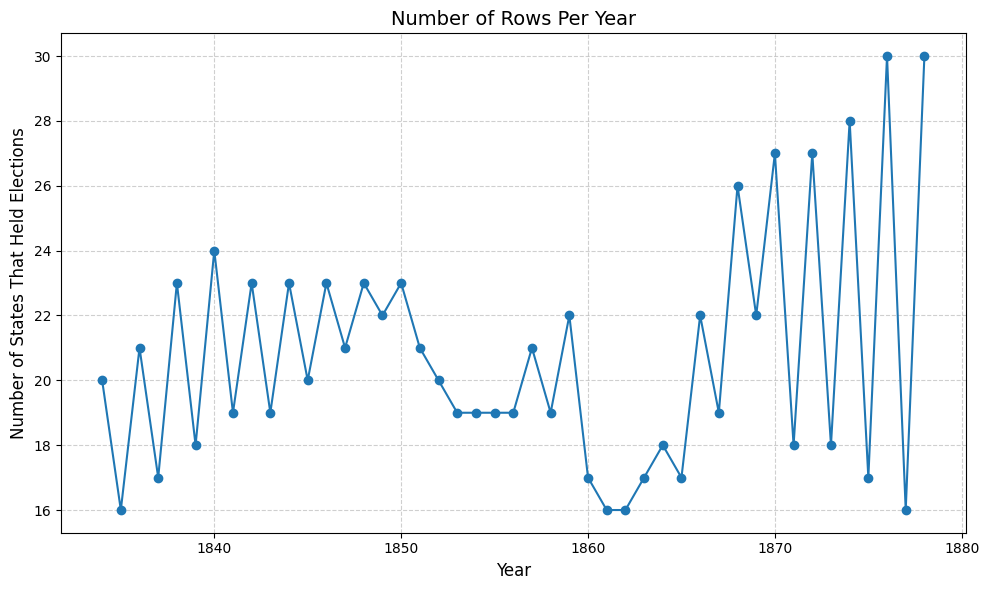

In [13]:
# Exploring occurrences of elections and control switches for odd years
# Count occurrences of each year and sort by year
year_counts = reshaped_df['year'].value_counts().sort_index()

# print(year_counts)

# Plot the counts
plt.figure(figsize=(10, 6))
plt.plot(year_counts.index, year_counts.values, marker='o')
plt.title('Number of Rows Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of States That Held Elections', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
odd_year_df = reshaped_df[reshaped_df['year'] % 2 != 0]

In [15]:
odd_year_df["state_abbrev"].unique()

array(['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA', 'IN', 'MI',
       'OH', 'WI', 'IA', 'MN', 'VA', 'AL', 'AR', 'FL', 'GA', 'LA', 'MS',
       'NC', 'SC', 'TX', 'KY', 'MD', 'TN', 'WV', 'CA'], dtype=object)

In [16]:
set(reshaped_df["state_abbrev"]) - set(odd_year_df["state_abbrev"]) 
print(reshaped_df['state_abbrev'].nunique())
print(odd_year_df['state_abbrev'].nunique())

38
30


In [17]:
# Initialize results
results = []

# Group by state
for state, group in odd_year_df.groupby('state_abbrev'):
    group = group.sort_values('year')
    
    # Identify years where LOW_HSE_DEM_PCT crosses 50%
    low_crossing_years = group.loc[(group['LOW_HSE_DEM_PCT'] > 50).astype(int).diff().abs() > 0, 'year']
    
    # Identify years where UPP_HSE_DEM_PCT crosses 50%
    upp_crossing_years = group.loc[(group['UPP_HSE_DEM_PCT'] > 50).astype(int).diff().abs() > 0, 'year']
    
    # Identify years where PARTY_OF_GOV changes
    party_change_years = group.loc[group['PARTY_OF_GOV'].diff().abs().gt(0), 'year']
    
    # Combine all years and count unique ones
    unique_years = pd.concat([low_crossing_years, upp_crossing_years, party_change_years]).unique()
    # print(unique_years)
    num_occurrences = len(unique_years)
    
    # Append results for this state
    results.append({
        'state': state,
        'num_occurrences': num_occurrences
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(results_df)

print(f"Number of switches by all states is {results_df['num_occurrences'].sum()}")

   state  num_occurrences
0     AL                4
1     AR                0
2     CA               10
3     CT               11
4     FL                1
5     GA               11
6     IA                0
7     IN                5
8     KY                4
9     LA                3
10    MA                2
11    MD                9
12    ME                5
13    MI                3
14    MN                1
15    MS                6
16    NC                1
17    NH                7
18    NJ               13
19    NY               14
20    OH               12
21    PA               12
22    RI                4
23    SC                0
24    TN                9
25    TX                2
26    VA                9
27    VT                1
28    WI                5
29    WV                0
Number of switches by all states is 164


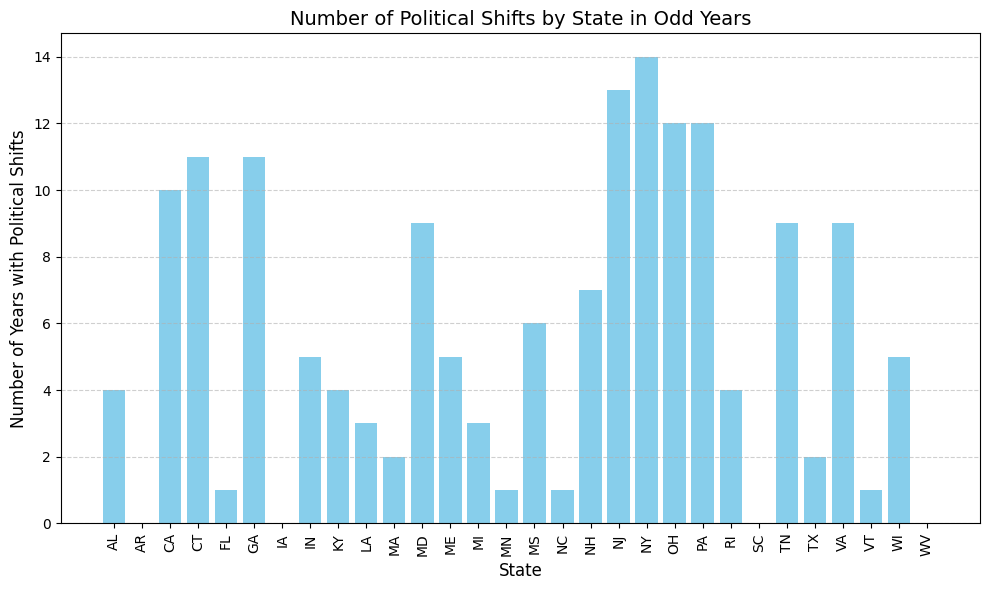

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['state'], results_df['num_occurrences'], color='skyblue')
plt.title('Number of Political Shifts by State in Odd Years', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Years with Political Shifts', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [19]:
reshaped_df = reshaped_df.drop(columns=['ICPR_STATE_CODE', 'UPP_HSE_DEM_PCT', 'UPP_HSE_W_R_PCT', 
'LOW_HSE_DEM_PCT', 'LOW_HSE_W_R_PCT', 'LOW_HSE_DEM_SEATS', 'LOW_HSE_W_R_SEATS', 'UPP_HSE_DEM_SEATS', 'UPP_HSE_W_R_SEATS', 
'UPP_HSE_TOTAL_SEATS', 'LOW_HSE_TOTAL_SEATS'])

reshaped_df = reshaped_df.rename(columns={"PARTY_OF_GOV": "gov_party"})

In [20]:
reshaped_df.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1834,<NA>,CT,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115
1,1835,1,CT,0.761905,0.238095,0.61165,0.38835,0.625551,0.374449
2,1836,1,CT,0.809524,0.190476,0.645631,0.354369,0.660793,0.339207
3,1837,1,CT,0.666667,0.333333,0.660377,0.339623,0.660944,0.339056
4,1838,<NA>,CT,0.047619,0.952381,0.273973,0.726027,0.245509,0.754491


In [21]:
df2 = dataframes["df_0002"]

# Replace 999 and 9999 with NaN (in the setup file missing values were coded this way)
df2 = df2.replace([999, 9999], np.nan)

# Identify columns that end with "OTH_SEATS" or "OTH_SEAT" because they are not relevant since we are analysing on two parties
columns_to_drop = [col for col in df2.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df2 = df2.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT' - these columns represent percentages but have formatting issues to be fixed
seat_columns = [col for col in df2.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df2[seat_columns] = df2[seat_columns] / 10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df2 = df2.rename(columns=renamed_columns)

columns_to_transform = [col for col in df2.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df2 = df2.melt(id_vars=["ICPR_STATE_CODE"], 
                      value_vars=columns_to_transform, 
                      var_name="year_variable", 
                      value_name="value")

# Extract year and variable from the melted column
melted_df2["year"] = melted_df2["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df2["variable"] = melted_df2["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df2 = melted_df2.drop(columns=["year_variable"])

# Reshape the DataFrame: each unique variable becomes its column
reshaped_df2 = melted_df2.pivot_table(index=["ICPR_STATE_CODE", "year"], 
                                      columns="variable", 
                                      values="value").reset_index()

# Identify non-percentage columns (those that do not end with '_PCT')
non_pct_columns = [col for col in reshaped_df2.columns if not col.endswith('_PCT')]

# Convert these columns to integers
reshaped_df2[non_pct_columns] = reshaped_df2[non_pct_columns].astype('Int64')

# I am re-mapping political parties using the same mapping I defined for the first dataset
reshaped_df2['PARTY_OF_GOV'] = reshaped_df2['PARTY_OF_GOV'].map(party_mapping)

# Convert PARTY_OF_GOV to integer
reshaped_df2['PARTY_OF_GOV'] = reshaped_df2['PARTY_OF_GOV'].astype('Int64')

# Map the ICPR_STATE_CODE to state abbreviations using the state mapping I defined for the first dataset
reshaped_df2['state_abbrev'] = reshaped_df2['ICPR_STATE_CODE'].map(state_mapping)

# Calculate the proportion of Democratic seats in the upper house
reshaped_df2['dem_upphse'] = reshaped_df2['UPP_HSE_DEM_SEATS'] / reshaped_df2['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df2 = reshaped_df2[reshaped_df2['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df2['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['UPP_HSE_DEM_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# Validate that the calculated proportion matches the percentage in the dataset
assert np.allclose(valid_df2['dem_upphse'] * 100, valid_df2['UPP_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

# Calculate the proportion of Republican seats in the upper house
reshaped_df2['rep_upphse'] = reshaped_df2['UPP_HSE_W_R_SEATS'] / reshaped_df2['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df2 = reshaped_df2[reshaped_df2['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df2['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['UPP_HSE_W_R_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# Validate that the calculated proportion matches the percentage in the dataset
assert np.allclose(valid_df2['rep_upphse'] * 100, valid_df2['UPP_HSE_W_R_PCT'], atol=0.1), \
    "Proportion of Republican seats should be equal to the percentage."

# Calculate the proportion of Democratic seats in the lower house
reshaped_df2['dem_lowhse'] = reshaped_df2['LOW_HSE_DEM_SEATS'] / reshaped_df2['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df2 = reshaped_df2[reshaped_df2['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df2['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['LOW_HSE_DEM_SEATS', 'LOW_HSE_TOTAL_SEATS'])

assert np.allclose(valid_df2['dem_lowhse'] * 100, valid_df2['LOW_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

# Calculate the proportion of Republican seats in the lower house
reshaped_df2['rep_lowhse'] = reshaped_df2['LOW_HSE_W_R_SEATS'] / reshaped_df2['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df2 = reshaped_df2[reshaped_df2['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df2['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS'])

# Note: This assertion is commented out because there is a single known mistake in the data, namely LOW_HSE_DEM_PCT is wrong for VA in 1885. It should be 30% instead of 0%.
# # Validate that the calculated proportion matches the percentage in the dataset
# assert np.allclose(valid_df2['rep_lowhse'] * 100, valid_df2['LOW_HSE_W_R_PCT'], atol=0.1), \
#     "Proportion of Republican seats should be equal to the percentage."

# Calculate the overall share of Democratic seats in the session (upper + lower house)
reshaped_df2['shr_dem_in_sess'] = (reshaped_df2['LOW_HSE_DEM_SEATS'] + reshaped_df2['UPP_HSE_DEM_SEATS']) / (reshaped_df2['LOW_HSE_TOTAL_SEATS'] + reshaped_df2['UPP_HSE_TOTAL_SEATS'])

# Calculate the overall share of Republican seats in the session (upper + lower house)
reshaped_df2['shr_rep_in_sess'] = (reshaped_df2['LOW_HSE_W_R_SEATS'] + reshaped_df2['UPP_HSE_W_R_SEATS']) / (reshaped_df2['LOW_HSE_TOTAL_SEATS'] + reshaped_df2['UPP_HSE_TOTAL_SEATS'])

# Dropping all the unnecessary columns
reshaped_df2 = reshaped_df2.drop(columns=['ICPR_STATE_CODE', 'UPP_HSE_DEM_PCT', 'UPP_HSE_W_R_PCT', 
'LOW_HSE_DEM_PCT', 'LOW_HSE_W_R_PCT', 'LOW_HSE_DEM_SEATS', 'LOW_HSE_W_R_SEATS', 'UPP_HSE_DEM_SEATS', 'UPP_HSE_W_R_SEATS', 
'UPP_HSE_TOTAL_SEATS', 'LOW_HSE_TOTAL_SEATS'])

reshaped_df2 = reshaped_df2.rename(columns={"PARTY_OF_GOV": "gov_party"})


In [22]:
print(f"Number of unique states: {reshaped_df2['state_abbrev'].nunique()}")

assert reshaped_df2['state_abbrev'].nunique() == 48, "By 1922 there should be 48 states."

assert reshaped_df2['year'].min() == 1879, "The minimum year should be 1879."
assert reshaped_df2['year'].max() == 1923, "The maximum year should be 1923."
assert reshaped_df2['year'].nunique() == 45, "There should be 45 unique years."
assert reshaped_df2['gov_party'].nunique() == 2, "There should be 2 unique parties."
valid_values = {1, 2}  
assert reshaped_df2['gov_party'].dropna().isin(valid_values).all(), "All values in 'PARTY_OF_GOV' should be 1, 2, or NaN."

# print(reshaped_df2.isna().sum())

Number of unique states: 48


In [23]:
reshaped_df2.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1879,2,CT,0.238095,0.761905,0.337398,0.658537,0.329588,0.666667
1,1880,2,CT,0.238095,0.761905,0.325203,0.666667,0.318352,0.674157
2,1881,2,CT,0.291667,0.708333,0.405622,0.590361,0.395604,0.600733
3,1882,1,CT,0.458333,0.541667,0.443548,0.556452,0.444853,0.555147
4,1883,1,CT,0.375,0.625,0.37751,0.62249,0.377289,0.622711


In [24]:
# Load the DataFrame
df3 = dataframes["df_0003"]

In [25]:
# Load the DataFrame
df3 = dataframes["df_0003"]

# Replace 999 and 9999 with NaN (in the setup file missing values were coded this way)
df3 = df3.replace([999, 9999], np.nan)

# Identify columns that end with "OTH_SEATS" or "OTH_SEAT" because they are not relevant since we are analysing on two parties
columns_to_drop = [col for col in df3.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df3 = df3.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT' - these columns represent percentages but have formatting issues to be fixed
seat_columns = [col for col in df3.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df3[seat_columns] = df3[seat_columns] / 10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df3 = df3.rename(columns=renamed_columns)

columns_to_transform = [col for col in df3.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df3 = df3.melt(id_vars=["ICPR_STATE_CODE"], 
                      value_vars=columns_to_transform, 
                      var_name="year_variable", 
                      value_name="value")

# Extract year and variable from the melted column
melted_df3["year"] = melted_df3["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df3["variable"] = melted_df3["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df3 = melted_df3.drop(columns=["year_variable"])

# Reshape the DataFrame: each unique variable becomes its column
reshaped_df3 = melted_df3.pivot_table(index=["ICPR_STATE_CODE", "year"], 
                                      columns="variable", 
                                      values="value").reset_index()

# Identify non-percentage columns (those that do not end with '_PCT')
non_pct_columns = [col for col in reshaped_df3.columns if not col.endswith('_PCT')]

# Convert these columns to integers
reshaped_df3[non_pct_columns] = reshaped_df3[non_pct_columns].astype('Int64')

# I am re-mapping political parties using the same mapping I defined for the first dataset
reshaped_df3['PARTY_OF_GOV'] = reshaped_df3['PARTY_OF_GOV'].map(party_mapping)

# Convert PARTY_OF_GOV to integer
reshaped_df3['PARTY_OF_GOV'] = reshaped_df3['PARTY_OF_GOV'].astype('Int64')

# Map the ICPR_STATE_CODE to state abbreviations using the state mapping I defined for the first dataset
reshaped_df3['state_abbrev'] = reshaped_df3['ICPR_STATE_CODE'].map(state_mapping)

# Calculate the proportion of Democratic seats in the upper house
reshaped_df3['dem_upphse'] = reshaped_df3['UPP_HSE_DEM_SEATS'] / reshaped_df3['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df3 = reshaped_df3[reshaped_df3['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df3['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats in senate should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['UPP_HSE_DEM_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# # Validate that the calculated proportion matches the percentage in the dataset
# Note: This assertion is commented out because there are three known mistakes in the data: clearly percentages for years 1966 and 1968 in SC are switched. MA has a mistake in 1974. The percentage should be 84.1% instead of 92.5%.
# variable  ICPR_STATE_CODE state_abbrev  year  UPP_HSE_DEM_PCT  dem_upphse
# 80                      3           MA  1974             92.5    0.840909
# 779                    48           SC  1966             94.0        0.88
# 780                    48           SC  1968             88.0        0.94
# assert np.allclose(valid_df3['dem_upphse'] * 100, valid_df3['UPP_HSE_DEM_PCT'], atol=0.1), \
#     "Proportion of Democratic seats in the Senate should be equal to the percentage."

# Calculate the proportion of Republican seats in the upper house
reshaped_df3['rep_upphse'] = reshaped_df3['UPP_HSE_W_R_SEATS'] / reshaped_df3['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats in senate should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df3 = reshaped_df3[reshaped_df3['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df3['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats in the Senate should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['UPP_HSE_W_R_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# Note: This assertion is commented out because there are three known mistakes in the data: the percentages are missing for year
# 1974 (for all or most states), and for SC additionally in 1966 and 1968. I have concerns re: how reliable this data is.
# # Validate that the calculated proportion matches the percentage in the dataset
# assert np.allclose(valid_df3['rep_upphse'] * 100, valid_df3['UPP_HSE_W_R_PCT'], atol=0.1), \
#     "Proportion of Republican seats in the Senate should be equal to the percentage."

# Calculate the proportion of Democratic seats in the lower house
reshaped_df3['dem_lowhse'] = reshaped_df3['LOW_HSE_DEM_SEATS'] / reshaped_df3['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats in the House of Representatives should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df3 = reshaped_df3[reshaped_df3['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df3['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats the House of Representatives should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['LOW_HSE_DEM_SEATS', 'LOW_HSE_TOTAL_SEATS'])

assert np.allclose(valid_df3['dem_lowhse'] * 100, valid_df3['LOW_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

# Calculate the proportion of Republican seats in the lower house
reshaped_df3['rep_lowhse'] = reshaped_df3['LOW_HSE_W_R_SEATS'] / reshaped_df3['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats in the House of Representatives should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df3 = reshaped_df3[reshaped_df3['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df3['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats the House of Representatives should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS'])

# Note: This assertion is commented out because there are three known mistakes in the data: the percentages are missing for year
# 1974 (for all or most states), and for SC additionally in 1966 and 1968. I have concerns re: how reliable this data is.
# # Validate that the calculated proportion matches the percentage in the dataset
# assert np.allclose(valid_df3['rep_lowhse'] * 100, valid_df3['LOW_HSE_W_R_PCT'], atol=0.1), \
#     "Proportion of Republican seats in the House of Representatives should be equal to the percentage."

# Calculate the overall share of Democratic seats in the session (upper + lower house)
reshaped_df3['shr_dem_in_sess'] = (reshaped_df3['LOW_HSE_DEM_SEATS'] + reshaped_df3['UPP_HSE_DEM_SEATS']) / (reshaped_df3['LOW_HSE_TOTAL_SEATS'] + reshaped_df3['UPP_HSE_TOTAL_SEATS'])

# Calculate the overall share of Republican seats in the session (upper + lower house)
reshaped_df3['shr_rep_in_sess'] = (reshaped_df3['LOW_HSE_W_R_SEATS'] + reshaped_df3['UPP_HSE_W_R_SEATS']) / (reshaped_df3['LOW_HSE_TOTAL_SEATS'] + reshaped_df3['UPP_HSE_TOTAL_SEATS'])

# Dropping all the unnecessary columns
reshaped_df3 = reshaped_df3.drop(columns=[
    'ICPR_STATE_CODE', 'UPP_HSE_DEM_PCT', 'UPP_HSE_W_R_PCT',
    'LOW_HSE_DEM_PCT', 'LOW_HSE_W_R_PCT', 'LOW_HSE_DEM_SEATS',
    'LOW_HSE_W_R_SEATS', 'UPP_HSE_DEM_SEATS', 'UPP_HSE_W_R_SEATS',
    'UPP_HSE_TOTAL_SEATS', 'LOW_HSE_TOTAL_SEATS', 'LOW_HSE_10TH_PCT', 
    'LOW_HSE_20TH_PCT', 'LOW_HSE_2_OTH_SEATS.1', 'LOW_HSE_REP_PCT', 
    'PARTY_CODE_OF_GOV','PARTY_OF_GOV.1', 'UPP_HSE_10TH_PCT', 
    'UPP_HSE_20TH_PCT', 'UPP_HSE_REP_PCT',
])

# Rename PARTY_OF_GOV column for clarity
reshaped_df3 = reshaped_df3.rename(columns={"PARTY_OF_GOV": "gov_party"})

In [26]:
# # Identify rows where the assertion fails - can be modified for any failing assertion
# failing_rows = valid_df3[
#     ~np.isclose(valid_df3['rep_lowhse'] * 100, valid_df3['LOW_HSE_W_R_PCT'], atol=0.1)
# ]

# print(failing_rows.shape)

# # Print the failing rows
# print(failing_rows[['ICPR_STATE_CODE', 'state_abbrev', 'year', 'LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS', 'LOW_HSE_DEM_SEATS', 'rep_lowhse', 'LOW_HSE_W_R_PCT']])

In [27]:
reshaped_df3['year'].max()

1974

In [28]:
print(f"Number of unique states: {reshaped_df3['state_abbrev'].nunique()}")

assert reshaped_df3['state_abbrev'].nunique() == 50, "By 1922 there should be 50 states."

assert reshaped_df3['year'].min() == 1924, "The minimum year should be 1924."
assert reshaped_df3['year'].max() == 1974, "The maximum year should be 1974."
assert reshaped_df3['year'].nunique() == 51, "There should be 51 unique years."
assert reshaped_df3['gov_party'].nunique() == 2, "There should be 2 unique parties."
valid_values = {1, 2}  
assert reshaped_df3['gov_party'].dropna().isin(valid_values).all(), "All values in 'PARTY_OF_GOV' should be 1, 2, or NaN."

Number of unique states: 50


In [29]:
df4 = dataframes["df_0004"]
print(df4['YEAR_OF_LEGISLATURE'].min())
print(df4['YEAR_OF_LEGISLATURE'].max())

df5 = dataframes["df_0005"]
# Identify columns that end with "OTH_SEATS" or "OTH_SEAT"
columns_to_drop = [col for col in df5.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df5 = df5.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT'
seat_columns = [col for col in df5.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df5[seat_columns] = df5[seat_columns]/10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df5 = df5.rename(columns=renamed_columns)

columns_to_transform = [col for col in df5.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df5 = df5.melt(id_vars=["ICPSR_STATE_CODE"], 
                    value_vars=columns_to_transform, 
                    var_name="year_variable", 
                    value_name="value")

# Extract year and variable from the melted column
melted_df5["year"] = melted_df5["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df5["variable"] = melted_df5["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df5 = melted_df5.drop(columns=["year_variable"])
print(melted_df5['year'].min())
print(melted_df5['year'].max())

834
974
1975
1985


In [30]:
icpsr_df = pd.concat([reshaped_df, reshaped_df2, reshaped_df3], axis=0)

In [31]:
icpsr_df.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1834,<NA>,CT,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115
1,1835,1,CT,0.761905,0.238095,0.61165,0.38835,0.625551,0.374449
2,1836,1,CT,0.809524,0.190476,0.645631,0.354369,0.660793,0.339207
3,1837,1,CT,0.666667,0.333333,0.660377,0.339623,0.660944,0.339056
4,1838,<NA>,CT,0.047619,0.952381,0.273973,0.726027,0.245509,0.754491


It is clear that df5 is just a continuation of df3 for years 1975-1985. Df4 is the same data but presented by year. We do not need either. 

I have a different data source available from **Carl Klarner** for years 1935-2011. It can be found in raw_data_dir folder called Klarner_stateComposition. The folder contains two datasets. The one I load as klarner1 contains the actual data cleaned by Klarner while klarner2 contains data about the data sources from which the dataset was derived along with multiple parameters re: how various data sources recorded various data point. All of this is recorded in Word documents that are in the same folder. This documentation also explains how odd states are handled. 

Tha paper in the folder discusses problems such as legislature switches mid_session and biases that come from a bad measure of party control. We have to accept many of those problems due to the fact that they are only solved in this dataset after 1935 and we have to use a less reliable source for before then. 

### My next steps: 
1. Bring data to the format in which all the data is which involves renaming variables and computing measures of proportions of dems and reps in session, i.e. in both legislative chambers. 
2. Filtering both ICPRS and Klarner datasets to overlap years, i.e. 1935-1975, and merging those two datasets to see the discrepancies so as to resolve any or at least inconsistencies between the two datasets coding
3. Dropping the years after 1935 from ICPSR dataset since it is less reliable of the sources, and appending Klarner dataset to it. 
4. I also have ncsl_state_composition data for years after 2011, that I will append after all that is done
5. The final step would be to append data for all US governors that I downloaded from here: https://github.com/jacobkap/governors, and making sure that the rest of my data is consistent with it. 

In [32]:
# # Keeping this cell so that you can easily load the data with info re: data sources

# klarner2 = pd.read_excel(os.path.join(raw_data_dir, "Klarner_partisan_composition/StatePartisanBalance1934to2011_SourceFiles_2011_05_24.xlsx"))

In [33]:
# Load Karl Klarner's dataset for years 1934-2011
klarner1_0 = pd.read_excel(os.path.join(raw_data_dir, "Klarner_partisan_composition/Partisan_Balance_For_Use2011_06_09b.xlsx"))

# Define columns to check for missing data
columns_to_check = [
    'govparty_c', 'sen_dem_prop_all', 'sen_rep_prop_all', 'hs_dem_prop_all', 'hs_rep_prop_all',
    'sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess',
    'hs_dem_in_sess', 'hs_rep_in_sess', 'hs_tot_in_sess'
]

# Create a boolean mask identifying rows where all `columns_to_check` are NA
mask = klarner1_0[columns_to_check].isna().all(axis=1)

identifiers = ['year', 'election_year', 'state', 'stateno', 'fips']

# Create a boolean mask identifying rows where all columns other than identifiers are NA
NA_mask = klarner1_0.loc[:, ~klarner1_0.columns.isin(identifiers)].isna().all(axis=1)

# Identify rows where all columns other than identifiers are NA
NaN_data = klarner1_0[mask]

# Inspect the distribution of `election_year` for NaN data
print("Data for how many states is missing each year?")
print(NaN_data['election_year'].value_counts())

Data for how many states is missing each year?
election_year
2011    50
2012    50
2013    50
2014    50
1934    50
1933    49
1935    45
1942     2
1946     2
1945     2
1944     2
1943     2
1938     2
1941     2
1940     2
1939     2
1937     2
1936     2
1947     2
Name: count, dtype: int64


From the output it is clear that for years 2011-2014 and 1934, all states formally exist in the data but all variables of interest apart from identificator columns are missing. 
Most data also seems to be missing for years 1934 and 1935 (or not all states were present in the data to begin with). And for years 1936-1947 data for two states is missing. I will now find out for which states. 

In [34]:
# Define years of interest to filter rows to drop
years_of_interest = [1942, 1946, 1945, 1944, 1943, 1938, 1941, 1940, 1939, 1937, 1936, 1947]

# Filter rows to drop for the specific years of interest
filtered_rows = NaN_data[NaN_data['election_year'].isin(years_of_interest)]

# Group by `election_year` and list unique states for each year
states_by_year = filtered_rows.groupby('election_year')['state'].unique()

# Display the states grouped by `election_year`
print(states_by_year)  # Alaska and Hawaii data are missing for years 1936-1947

election_year
1936    [Alaska, Hawaii]
1937    [Alaska, Hawaii]
1938    [Alaska, Hawaii]
1939    [Alaska, Hawaii]
1940    [Alaska, Hawaii]
1941    [Alaska, Hawaii]
1942    [Alaska, Hawaii]
1943    [Alaska, Hawaii]
1944    [Alaska, Hawaii]
1945    [Alaska, Hawaii]
1946    [Alaska, Hawaii]
1947    [Alaska, Hawaii]
Name: state, dtype: object


In [35]:

# Remove rows where all `columns_to_check` are NA from `klarner1_0`
klarner_noNAs = klarner1_0[~mask]

# Print the count of `election_year` values, ordered by year
print("Number of states in data for each election year:")
print(klarner_noNAs['election_year'].value_counts().sort_index())

# When we drop all columns with NAs in non_dentification columns,
# we drop all observations before 1935 and after 2010, and in 1935 we only have five states.

# Filter data for 1935 and list unique states
states_1935 = klarner_noNAs[klarner_noNAs['election_year'] == 1935]['state'].unique()

# Display the result
print(states_1935)

Number of states in data for each election year:
election_year
1935     5
1936    48
1937    48
1938    48
1939    48
        ..
2006    50
2007    50
2008    50
2009    50
2010    50
Name: count, Length: 76, dtype: int64
['Kentucky' 'Mississippi' 'New Jersey' 'Virginia' 'New York']


In [36]:
# Keeping only the columns that are needed for the analysis
klarner1 = klarner_noNAs[['state', 'election_year', 'sen_dem_prop_all', 'sen_rep_prop_all', 'hs_dem_prop_all', 
'hs_rep_prop_all', 'sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess', 'hs_dem_in_sess', 
'hs_rep_in_sess', 'hs_tot_in_sess', 'govparty_c']].copy()

# Dictionary mapping state names to abbreviations
state_to_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

# Add a new column to the DataFrame with the abbreviations
klarner1.loc[:, 'state_abbrev'] = klarner1['state'].map(state_to_abbrev)

# Since in ICPSR I only have state abbreviations, I will drop the column containing the full state names
klarner1 = klarner1.drop(columns=['state'])

# Rename the columns to match the ICPSR dataset
klarner1 = klarner1.rename(columns={
    'election_year': 'year',
    'govparty_c': 'gov_party',
    'sen_dem_prop_all': 'dem_upphse',
    'sen_rep_prop_all': 'rep_upphse',
    'hs_dem_prop_all': 'dem_lowhse',
    'hs_rep_prop_all': 'rep_lowhse',
})

# Keeping only the final dataset columns and the columns needed to calculate the share of Democrats and Republicans in the session
klarner1 = klarner1[[
    'year', 'state_abbrev', 'gov_party',
    'dem_upphse', 'rep_upphse', 'dem_lowhse', 'rep_lowhse',
    'sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess',
    'hs_dem_in_sess', 'hs_rep_in_sess', 'hs_tot_in_sess'
]]

# Calculate the overall share of Democratic and Republican seats in the session (upper + lower house) - this measure is not available in the dataset
klarner1['shr_dem_in_sess'] = (klarner1['sen_dem_in_sess'] + klarner1['hs_dem_in_sess']) / (klarner1['hs_tot_in_sess'] + klarner1['sen_tot_in_sess'])
klarner1['shr_rep_in_sess'] = (klarner1['sen_rep_in_sess'] + klarner1['hs_rep_in_sess']) / (klarner1['hs_tot_in_sess'] + klarner1['sen_tot_in_sess'])

# Drop the columns that were used for calculating overall share of dem/rep seats in the session and are not needed anymore
klarner1 = klarner1.drop(columns=['sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess', 'hs_dem_in_sess', 'hs_rep_in_sess', 'hs_tot_in_sess'])

# In the Klarner dataset democrats are coded as 1 like I map ICPSR data, but Republicans are coded as 0, not 2. 
# I will change this to match ICPSR data. Value 0.5 signify non-major party governor, however I was just 
# dropping those values in ICPSR data, and they are automatically dropped with the mapping.
klarner1['gov_party'] = klarner1['gov_party'].map({1.0: 1, 0.0: 2})

print(klarner1.sample(5, random_state = 44))

      year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
473   1962           ID        2.0    0.477273    0.522727    0.460317   
1705  1964           UT        1.0    0.555556    0.444444    0.565217   
1683  2006           TX        2.0    0.354839    0.645161    0.460000   
366   1969           GA        1.0    0.875000    0.125000    0.856410   
1728  2003           UT        2.0    0.241379    0.758621    0.253333   

      rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
473     0.539683         0.467290         0.532710  
1705    0.434783         0.562500         0.437500  
1683    0.540000         0.441989         0.558011  
366     0.138461         0.860558         0.135458  
1728    0.746667         0.250000         0.750000  


In [37]:
# Check the number of unique states
print(f"Number of unique states: {klarner1['state_abbrev'].nunique()}")

# Assertions
assert klarner1['state_abbrev'].nunique() == 50, "There should be 50 states."

assert klarner1['year'].min() == 1935, "The minimum year should be 1935."
assert klarner1['year'].max() == 2010, "The maximum year should be 2010 because the election year should be off-set one year back."
assert klarner1['year'].nunique() == 76, "There should be 76 unique years."

assert klarner1['gov_party'].nunique() == 2, "There should be 2 unique parties."

# Check if all values in 'gov_party' are valid
valid_values = {1, 2}  
assert klarner1['gov_party'].dropna().isin(valid_values).all(), "All values in 'gov_party' should be 1, 2, or NaN."

Number of unique states: 50


In [38]:
klarner_CA = klarner1[klarner1['state_abbrev'] == 'CA']
print(klarner_CA.head())

     year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
160  1942           CA        2.0       0.400       0.575     0.45000   
161  1943           CA        2.0       0.400       0.575     0.45000   
162  1944           CA        2.0       0.325       0.675     0.47500   
163  1945           CA        2.0       0.325       0.675     0.47500   
164  1946           CA        2.0       0.275       0.650     0.37037   

     rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
160    0.550000         0.433333         0.558333  
161    0.550000         0.433333         0.558333  
162    0.525000         0.425000         0.575000  
163    0.525000         0.425000         0.575000  
164    0.592593         0.338843         0.611570  


In [40]:
icpsr_filt = icpsr_df[icpsr_df['year'] >= 1935]
klarner_filt = klarner1[klarner1['year'] <= 1975]

icpsr_filt_even = icpsr_filt[icpsr_filt['year'] % 2 == 0]
klarner_filt_even = klarner_filt[klarner_filt['year'] % 2 == 0]


In [43]:
print(icpsr_filt.sample(3, random_state=44))

variable  year  gov_party state_abbrev  dem_upphse  rep_upphse  dem_lowhse  \
840       1938          1           MD    0.793103    0.206897    0.866667   
1107      1944          1           UT    0.782609    0.217391        0.75   
178       1954          2           DE    0.705882    0.294118    0.771429   

variable  rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
840         0.133333         0.852349         0.147651  
1107            0.25         0.759036         0.240964  
178         0.228571             0.75             0.25  


In [75]:
print(icpsr_filt['year'].value_counts().sort_index().head(8))

year
1935     5
1936    42
1937     4
1938    42
1939    46
1940    42
1941     3
1942    42
Name: count, dtype: Int64


In [66]:
# Step 1: Create a complete grid of years and states
years = icpsr_filt['year'].unique()
states = icpsr_filt['state_abbrev'].unique()

# Create a DataFrame with all combinations
all_combos = pd.MultiIndex.from_product([years, states], names=['year', 'state_abbrev']).to_frame(index=False)

# Step 2: Merge the complete grid with the original dataset
icpsr_complete = pd.merge(all_combos, icpsr_filt, on=['year', 'state_abbrev'], how='left')


In [70]:
icpsr_filt[icpsr_filt['year'] == 1941].head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
206,1941,1,NJ,0.190476,0.809524,0.266667,0.733333,0.246914,0.753086
577,1941,1,VA,0.95,0.05,0.96,0.04,0.957143,0.042857
819,1941,1,KY,0.763158,0.236842,0.75,0.25,0.753623,0.246377


In [71]:
all_combos[all_combos['year'] == 1941].head()

,year,state_abbrev
1150,1941,CT
1151,1941,ME
1152,1941,MA
1153,1941,NH
1154,1941,RI


In [72]:
icpsr_complete[icpsr_complete['year'] == 1941].head()

,year,state_abbrev,gov_party,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
1150,1941,CT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1151,1941,ME,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1152,1941,MA,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1153,1941,NH,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1154,1941,RI,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [46]:
print(icpsr_complete['year'].value_counts().sort_index())

year
1935    50
1936    50
1937    50
1938    50
1939    50
1940    50
1941    50
1942    50
1943    50
1944    50
1945    50
1946    50
1947    50
1948    50
1949    50
1950    50
1951    50
1952    50
1953    50
1954    50
1955    50
1956    50
1957    50
1958    50
1959    50
1960    50
1961    50
1962    50
1963    50
1964    50
1965    50
1966    50
1967    50
1968    50
1969    50
1970    50
1971    50
1972    50
1973    50
1974    50
Name: count, dtype: Int64


In [56]:
icpsr_complete[icpsr_complete['state_abbrev'] == 'CT'].head()

,year,state_abbrev,gov_party,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1936,CT,1,0.742857,0.257143,0.374532,0.625468,0.417219,0.582781
50,1938,CT,2,0.485714,0.457143,0.2397,0.752809,0.268212,0.718543
100,1939,CT,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
150,1940,CT,1,0.628571,0.371429,0.319853,0.680147,0.355049,0.644951
200,1942,CT,2,0.416667,0.583333,0.275735,0.720588,0.292208,0.704545


In [90]:
# Identify identifier columns (e.g., year and state_abbrev)
id_cols = ['year', 'state_abbrev']
gov_id_cols = ['year', 'state_abbrev', 'gov_party']

# Identify non-identifier columns
non_id_cols = [col for col in icpsr_complete.columns if col not in identifier_cols]
non_gov_id_cols = [col for col in icpsr_complete.columns if col not in gov_id_cols] 

# # Step 1: Mark rows where all non-identifier columns are NaN
icpsr_complete['all_empty_but_id'] = icpsr_complete[non_id_cols].isna().all(axis=1)
icpsr_complete['all_empty_but_gov_id'] = icpsr_complete[non_gov_id_cols].isna().all(axis=1)

print(f"length of non_id_cols is {icpsr_complete['all_empty_but_id'].sum()}")
print(f"length of non_gov_id_cols is {icpsr_complete['all_empty_but_gov_id'].sum()}")

# Step 2: Forward-fill for rows with all non-identifier columns NaN
# Group by state_abbrev and fill based on the previous year
def fill_all_empty(group):
    group.loc[group['all_empty_but_id'], non_id_cols] = group[non_id_cols].ffill()
    group.loc[group['all_empty_but_gov_id'], non_gov_id_cols] = group[non_gov_id_cols].ffill()
    return group

print(icpsr_complete[icpsr_complete['state_abbrev'] == 'CA'].head(3))

icpsr_complete = icpsr_complete.groupby('state_abbrev', group_keys=False).apply(fill_all_empty)

print(icpsr_complete[icpsr_complete['state_abbrev'] == 'CA'].head(3))

# icpsr_complete = icpsr_complete.groupby('state_abbrev', group_keys=False).apply(fill_all_empty)
icpsr_complete.drop(columns=['all_empty_but_id'], inplace=True)
icpsr_complete.drop(columns=['all_empty_but_gov_id'], inplace=True)


length of non_id_cols is 1034
length of non_gov_id_cols is 1077
     year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
45   1936           CA          2       0.375       0.625      0.5875   
95   1938           CA          1        0.45        0.55        0.55   
145  1939           CA          2        <NA>        <NA>        <NA>   

     rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  all_empty_but_id  \
45       0.4125         0.516667         0.483333             False   
95         0.45         0.516667         0.483333             False   
145        <NA>             <NA>             <NA>             False   

     all_empty_but_gov_id  
45                  False  
95                  False  
145                  True  
     year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
45   1936           CA          2       0.375       0.625      0.5875   
95   1938           CA          1        0.45        0.55        0.55   
145  1939           CA     

/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_13185/4208259576.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  icpsr_complete = icpsr_complete.groupby('state_abbrev', group_keys=False).apply(fill_all_empty)


In [91]:
# Verify the results
print(icpsr_complete[icpsr_complete['state_abbrev'] == 'CA'].head())

     year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
45   1936           CA          2       0.375       0.625      0.5875   
95   1938           CA          1        0.45        0.55        0.55   
145  1939           CA          2        0.45        0.55        0.55   
195  1940           CA          1         0.4         0.6       0.525   
245  1942           CA          2         0.4         0.6        0.45   

     rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
45       0.4125         0.516667         0.483333  
95         0.45         0.516667         0.483333  
145        0.45         0.516667         0.483333  
195       0.475         0.483333         0.516667  
245        0.55         0.433333         0.566667  


In [53]:
icpsr_complete[icpsr_complete['state_abbrev'] == 'CT'].head()

,year,state_abbrev,gov_party,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1936,CT,1,0.742857,0.257143,0.374532,0.625468,0.417219,0.582781
50,1938,CT,2,0.485714,0.457143,0.2397,0.752809,0.268212,0.718543
100,1939,CT,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
150,1940,CT,1,0.628571,0.371429,0.319853,0.680147,0.355049,0.644951
200,1942,CT,2,0.416667,0.583333,0.275735,0.720588,0.292208,0.704545


In [ ]:
merged_even = pd.merge(klarner_filt_even, icpsr_filt_even, on=['year', 'state_abbrev'], suffixes=('_klarner', '_icpsr'), how='outer')

# Reorder the columns
merged_even = merged_even[['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr',
                           'dem_upphse_klarner', 'dem_upphse_icpsr', 'rep_upphse_klarner', 
                           'rep_upphse_icpsr', 'dem_lowhse_klarner', 'dem_lowhse_icpsr', 
                           'rep_lowhse_klarner', 'rep_lowhse_icpsr', 'shr_dem_in_sess_klarner', 
                           'shr_dem_in_sess_icpsr', 'shr_rep_in_sess_klarner', 'shr_rep_in_sess_icpsr']]

In [ ]:
merged_even.sample(5, random_state=44)

,year,state_abbrev,gov_party_klarner,gov_party_icpsr,dem_upphse_klarner,dem_upphse_icpsr,rep_upphse_klarner,rep_upphse_icpsr,dem_lowhse_klarner,dem_lowhse_icpsr,rep_lowhse_klarner,rep_lowhse_icpsr,shr_dem_in_sess_klarner,shr_dem_in_sess_icpsr,shr_rep_in_sess_klarner,shr_rep_in_sess_icpsr
41,1936,UT,1.0,1,0.956522,0.956522,0.043478,0.043478,0.933333,0.933333,0.066667,0.066667,0.939759,0.939759,0.060241,0.060241
32,1936,OH,1.0,1,0.861111,0.861111,0.138889,0.138889,0.760870,0.76087,0.239130,0.23913,0.781609,0.781609,0.218391,0.218391
345,1950,DE,1.0,1,0.529412,0.529412,0.470588,0.470588,0.457143,0.457143,0.542857,0.542857,0.480769,0.480769,0.519231,0.519231
64,1938,MA,2.0,2,0.300000,0.3,0.700000,0.7,0.408333,0.404167,0.591667,0.595833,0.392857,0.389286,0.607143,0.610714
347,1950,GA,1.0,1,1.000000,1.0,0.000000,0.0,0.995122,1.0,0.004878,0.0,0.996139,1.0,0.003861,0.0


In [ ]:
# Display rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr'
unequal_rows_gov = merged_even[merged_even['gov_party_klarner'] != merged_even['gov_party_icpsr']]
print(f"There are {unequal_rows_gov.shape[0]} rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr'.")
print(unequal_rows_gov)


There are 10 rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr'.
     year state_abbrev  gov_party_klarner  gov_party_icpsr  \
80   1938           OH                2.0                1   
175  1942           NY                2.0                1   
337  1948           WY                2.0                1   
343  1950           CO                2.0                1   
471  1954           NY                1.0                2   
571  1958           NY                2.0                1   
731  1964           UT                1.0                2   
781  1966           UT                1.0                2   
807  1968           MD                1.0                2   
831  1968           UT                1.0                2   

     dem_upphse_klarner  dem_upphse_icpsr  rep_upphse_klarner  \
80             0.228571          0.228571            0.771429   
175            0.392157          0.392157            0.607843   
337            0.333333          0.333333  

In [ ]:
# Here is a dataset to double-check the problematic years with links to sources generated by ChatGPT
# Create the DataFrame
data = {
    "year": [1938, 1942, 1948, 1950, 1954, 1958, 1964, 1966, 1968, 1968],
    "state_abbrev": ["OH", "NY", "WY", "CO", "NY", "NY", "UT", "UT", "MD", "UT"],
    "governor": [
        "John W. Bricker", "Thomas E. Dewey", "Arthur G. Crane", "Daniel I.J. Thornton",
        "W. Averell Harriman", "Nelson A. Rockefeller", "Cal Rampton", "Cal Rampton",
        "Marvin Mandel", "Cal Rampton"
    ],
    "party_code": [2, 2, 2, 2, 1, 2, 1, 1, 1, 1],
    "source_url": [
        "https://en.wikipedia.org/wiki/1938_Ohio_gubernatorial_election",
        "https://en.wikipedia.org/wiki/1942_New_York_state_election",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Wyoming",
        "https://en.wikipedia.org/wiki/1950_Colorado_gubernatorial_election",
        "https://en.wikipedia.org/wiki/1954_New_York_state_election",
        "https://en.wikipedia.org/wiki/1958_New_York_state_election",
        "https://en.wikipedia.org/wiki/1964_Utah_gubernatorial_election",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Utah",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Maryland",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Utah"
    ]
}

gov_mismatch = pd.DataFrame(data)

# Perform an inner merge to compare rows based on 'year' and 'state_abbrev'
comparison = unequal_rows_gov.merge(gov_mismatch, on=['year', 'state_abbrev'], how='inner')

# Identify mismatched rows where 'gov_party_klarner' does not match 'party_code'
mismatched_rows_klarner = comparison[comparison['gov_party_klarner'] != comparison['party_code']]

# Display the mismatched rows
print(f"Number of rows that are mismatched between Klarner and the correct data: {mismatched_rows_klarner.shape[0]}")

# Identify mismatched rows where 'gov_party_icpsr' does not match 'party_code'
mismatched_rows_icpsr = comparison[comparison['gov_party_icpsr'] != comparison['party_code']]

# Display the mismatched rows
print(f"Number of rows that are mismatched between ICPSR and the correct data: {mismatched_rows_icpsr.shape[0]}")

print("Thus it is clear that Klarner is the more accurate dataset, and all the instances of mismatch are due to errors in ICPSR data.")

Number of rows that are mismatched between Klarner and the correct data: 0
Number of rows that are mismatched between ICPSR and the correct data: 10
Thus it is clear that Klarner is the more accurate dataset, and all the instances of mismatch are due to errors in ICPSR data.


In [ ]:
# Identify rows where 'dem_upphse_klarner' and 'dem_upphse_icpsr' are not close, excluding rows where both are NaN
unequal_rows_dem_upphse = merged_even[
    ~np.isclose(merged_even['dem_upphse_klarner'], merged_even['dem_upphse_icpsr'], atol=0.05) &
    ~(merged_even['dem_upphse_klarner'].isna() & merged_even['dem_upphse_icpsr'].isna())
]

unequal_rows_dem_upphse = unequal_rows_dem_upphse[['year', 'state_abbrev', 'dem_upphse_klarner', 'dem_upphse_icpsr']]

# Print the number of rows where the values are not equal
print(f"There are {unequal_rows_dem_upphse.shape[0]} rows where 'dem_upphse_klarner' is not equal to 'dem_upphse_icpsr'.")

# Display the mismatched rows
print(unequal_rows_dem_upphse)

There are 131 rows where 'dem_upphse_klarner' is not equal to 'dem_upphse_icpsr'.
     year state_abbrev  dem_upphse_klarner  dem_upphse_icpsr
0    1936           AL                 NaN               1.0
14   1936           KY            0.684211              <NA>
22   1936           MS            1.000000              <NA>
42   1936           VA            0.950000              <NA>
44   1936           WA            0.804348          0.891304
..    ...          ...                 ...               ...
912  1972           MS            0.961538              <NA>
918  1972           NJ            0.400000              <NA>
924  1972           OR            0.600000          0.533333
932  1972           VA            0.825000              <NA>
937  1972           WY            0.433333          0.366667

[131 rows x 4 columns]


In [ ]:
# We can see that out of 6 states for which mismatch occurs most often, 
# five states have odd-year state elections, i.e. MA, VA, KY, NJ, and LA which 
# suggests that they are coded differently in the two datasets.
unequal_rows_dem_upphse['state_abbrev'].value_counts()

state_abbrev
MS    19
VA    19
KY    18
NJ    12
MN    12
LA     9
HI     7
MD     7
AK     5
VT     3
NV     2
IN     2
ME     2
ID     1
UT     1
RI     1
OR     1
CT     1
ND     1
AL     1
CO     1
WV     1
WI     1
TN     1
NH     1
WA     1
WY     1
Name: count, dtype: int64

In [ ]:
unequal_rows_dem_upphse_odd_states = unequal_rows_dem_upphse[unequal_rows_dem_upphse['state_abbrev'].isin(['MS', 'VA', 'KY', 'NJ', 'LA'])]

# # Display the mismatched rows for odd-year state elections
# print(unequal_rows_dem_upphse_odd_states)

print(unequal_rows_dem_upphse_odd_states['dem_upphse_icpsr'].value_counts(dropna = False))
# We can see that the ICPSR data has a lot of missing values for these states in eveh years where Klarner does not meaning 
# in ICPSR the data is only available for the actual election years.

print(unequal_rows_dem_upphse_odd_states.dropna()) 
# In the remaining rows it seems like ICPSR values are just rounded up Klarner values.

dem_upphse_icpsr
<NA>    77
Name: count, dtype: Int64
Empty DataFrame
Columns: [year, state_abbrev, dem_upphse_klarner, dem_upphse_icpsr]
Index: []


In [ ]:
unequal_rows_dem_upphse_only_even_states = unequal_rows_dem_upphse[~unequal_rows_dem_upphse['state_abbrev'].isin(['MS', 'VA', 'KY', 'NJ', 'LA'])]

# Display the mismatched rows for even-year state elections
print(unequal_rows_dem_upphse_only_even_states)

# Mostly those differences are small, and are probably caused by adjustments in the Klarner dataset or mistakes/missing data in icpsr data.

     year state_abbrev  dem_upphse_klarner  dem_upphse_icpsr
0    1936           AL                 NaN               1.0
44   1936           WA            0.804348          0.891304
113  1940           MD            0.793103              <NA>
171  1942           NH            0.291667             0.375
183  1942           TN            0.848485          0.909091
209  1944           MD            0.689655              <NA>
252  1946           IN            0.360000               0.2
258  1946           ME            0.090909          0.030303
270  1946           NV            0.411765          0.470588
288  1948           AK            0.500000              <NA>
298  1948           HI            0.333333              <NA>
307  1948           MD            0.620690              <NA>
335  1948           WI            0.151515          0.066667
338  1950           AK            0.500000              <NA>
348  1950           HI            0.400000              <NA>
352  1950           IN  

In [ ]:
# Filter and print rows where 'dem_upphse_klarner' is NA
print(unequal_rows_dem_upphse_only_even_states[unequal_rows_dem_upphse_only_even_states['dem_upphse_klarner'].isna()])

merged_even[(merged_even['state_abbrev'] == 'AL') & (merged_even['year'] == 1936)]

# There is missing data for Alabama in 1936 in the Klarner dataset, 
# and the ICPSR dataset has a value of 0.0 for the Democratic proportion in the upper house which is correct. 

   year state_abbrev  dem_upphse_klarner  dem_upphse_icpsr
0  1936           AL                 NaN               1.0


,year,state_abbrev,gov_party_klarner,gov_party_icpsr,dem_upphse_klarner,dem_upphse_icpsr,rep_upphse_klarner,rep_upphse_icpsr,dem_lowhse_klarner,dem_lowhse_icpsr,rep_lowhse_klarner,rep_lowhse_icpsr,shr_dem_in_sess_klarner,shr_dem_in_sess_icpsr,shr_rep_in_sess_klarner,shr_rep_in_sess_icpsr
0,1936,AL,1.0,1,NaN,1.0,NaN,0.0,NaN,0.990566,NaN,0.009434,NaN,0.992908,NaN,0.007092


In [ ]:
# Exclude rows already in unequal_rows_dem_upphse
remaining_rows = merged_even.loc[~merged_even.index.isin(unequal_rows_dem_upphse.index)]

# Identify rows where 'rep_upphse_klarner' and 'rep_upphse_icpsr' are not close, excluding NaN matches
unequal_rows_rep_upphse = remaining_rows[
    ~np.isclose(remaining_rows['rep_upphse_klarner'], remaining_rows['rep_upphse_icpsr'], atol=0.05) &
    ~(remaining_rows['rep_upphse_klarner'].isna() & remaining_rows['rep_upphse_icpsr'].isna())
]

# Display the results
print(f"There are {unequal_rows_rep_upphse.shape[0]} rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.")
print(unequal_rows_rep_upphse[['year', 'state_abbrev', 'rep_upphse_klarner', 'rep_upphse_icpsr']])
# i double-ckecked that Klarner data is correct for the row with a mismatch.

There are 1 rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.
     year state_abbrev  rep_upphse_klarner  rep_upphse_icpsr
945  1974           DE            0.380952          0.142857


In [ ]:
unequal_rows_dem_lowhse = remaining_rows[
    ~np.isclose(remaining_rows['dem_lowhse_klarner'], remaining_rows['dem_lowhse_icpsr'], atol=0.05) &
    ~(remaining_rows['dem_lowhse_klarner'].isna() & remaining_rows['dem_lowhse_icpsr'].isna())
]

# Display the results
print(f"There are {unequal_rows_dem_lowhse.shape[0]} rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.")
print(unequal_rows_dem_lowhse[['year', 'state_abbrev', 'dem_lowhse_klarner', 'dem_lowhse_icpsr']])

There are 26 rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.
     year state_abbrev  dem_lowhse_klarner  dem_lowhse_icpsr
28   1936           NJ            0.350000              0.65
38   1936           SD            0.359223          0.173333
46   1936           WV            0.765957           0.87234
106  1940           ID            0.644068          0.559322
134  1940           SD            0.133333              0.08
239  1944           WY            0.500000          0.363636
269  1946           NM            0.612245          0.734694
278  1946           SD            0.053333          0.146667
283  1946           VT            0.113821          0.052846
287  1946           WY            0.303571          0.236364
319  1948           NM            0.734694          0.816327
337  1948           WY            0.375000               0.5
378  1950           SD            0.120000          0.026667
387  1950           WY            0.214286          0.303571
428 

In [ ]:
merged_even.shape

(989, 16)

In [ ]:
klarner2[['year', 'election_year', 'state', 'year3', 'odd_year_state', 'stlg_elections_this_year']][klarner2['odd_year_state'] == 1].sample(10, random_state=44)

,year,election_year,state,year3,odd_year_state,stlg_elections_this_year
4770,1948,1947,New Jersey,NaN,1,1.0
2905,1969,1969,Louisiana,1969,1,0.0
4840,1936,1935,New Jersey,NaN,1,1.0
4845,1941,1940,New Jersey,NaN,1,1.0
7381,1935,1934,Virginia,NaN,1,NaN
2747,1975,1974,Kentucky,1975,1,0.0
4872,1968,1967,New Jersey,1968,1,1.0
4851,1947,1946,New Jersey,NaN,1,1.0
2921,1985,1984,Louisiana,1985,1,0.0
2692,2002,2001,Kentucky,2002,1,0.0


In [ ]:
assert merged_even['gov_party_klarner'].equals(merged_even['gov_party_icpsr']), "The 'gov_party' columns from different datasets are not equal."

In [ ]:
icpsr_df.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1834,<NA>,CT,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115
1,1835,1,CT,0.761905,0.238095,0.61165,0.38835,0.625551,0.374449
2,1836,1,CT,0.809524,0.190476,0.645631,0.354369,0.660793,0.339207
3,1837,1,CT,0.666667,0.333333,0.660377,0.339623,0.660944,0.339056
4,1838,<NA>,CT,0.047619,0.952381,0.273973,0.726027,0.245509,0.754491
